In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import native_rescheduler
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize
from sklearn import linear_model
from statsmodels.formula.api import ols

## Add to feature set:

In [2]:
feature_id = ['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']    

def get_feature_set(G, psize):
    
    lst = []
    in_degree_lst = G.in_degree
    out_degree_lst = G.out_degree
    in_bet_lst = nx.algorithms.in_degree_centrality(G)
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    for node in G.nodes:
        in_degree = in_degree_lst[node]
        out_degree = out_degree_lst[node]
        in_bet = in_bet_lst[node]
        # print("in betweennes", in_bet)
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        # print("out_betweennes", out_bet)
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        num_descendants = len(descendants) 
        longest_descendant_path = nx.dag_longest_path_length(G.subgraph(descendants)) 
        lst.append((in_degree, out_degree, num_descendants, longest_descendant_path, in_bet, out_bet, trophic, psize[node]))      
    return lst

## Create Groundtruth Data:

In [3]:
data = []

tie_breaking_rule = 2
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] !=-1:
            psize = speed_to_psize(speeds)
            feature_set = get_feature_set(G, psize)
                # make_graph_visual(G, num_tasks)
            data = data + feature_set


I is  1
I is  2
I is  3
I is  4
I is  5
I is  6
I is  7
I is  8
I is  9
I is  10
I is  11
I is  12
I is  13
I is  14
I is  15
I is  16
I is  17
I is  18
I is  19


## Visually verify correlation between feature and pseudosize:

In [4]:
#load data into Dataframe
df = pd.DataFrame.from_records(data, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])    

In [5]:
df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']].to_csv("train_data.csv")

df[["psize"]].to_csv("train_labels.csv")

      in_degree  out_degree  num_descendants  longest_descendant_path  \
0             0           3                4                        2   
1             0           0                1                        0   
2             0           1                2                        1   
3             2           0                1                        0   
4             1           1                2                        1   
...         ...         ...              ...                      ...   
1302          3           1                3                        2   
1303          3           2                3                        2   
1304          7           1                2                        1   
1305          8           1                2                        1   
1306          9           0                1                        0   

      in_degree_betweenness_centrality  out_degree_betweenness_centrality  \
0                             0.000000        

Feature: in_degree


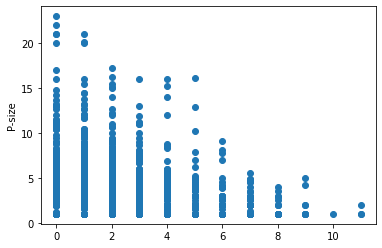

----
Feature: out_degree


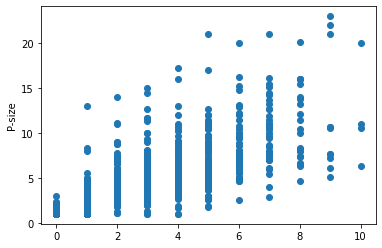

----
Feature: num_descendants


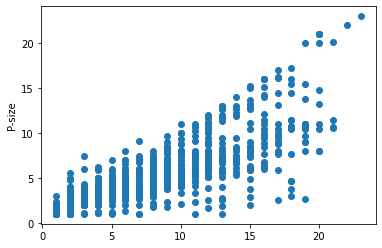

----
Feature: longest_descendant_path


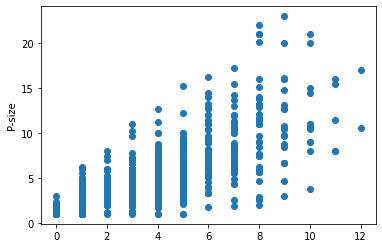

----
Feature: in_degree_betweenness_centrality


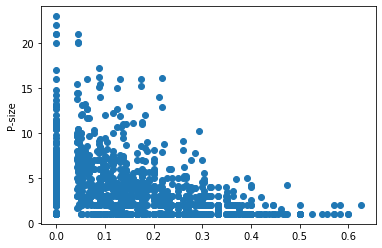

----
Feature: out_degree_betweenness_centrality


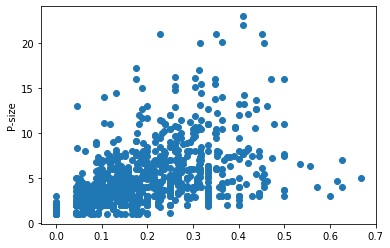

----
Feature: trophic_levels


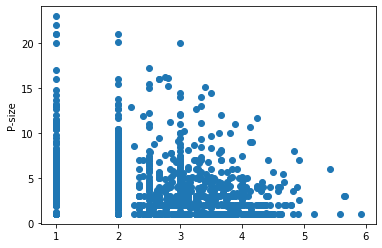

----


In [6]:
for col in df.columns:
    if col == 'psize':
        continue
    print('Feature: ' + col)
    plt.scatter(df[col], df.psize)
    plt.ylabel('P-size')
    plt.show()
    print('----')

# Get Model Summary to see which variables are important and which are not

In [11]:
import statsmodels.api as sm
import numpy as np
X = df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']]

X = sm.add_constant(X)

print(np.asarray(X))

Y = df['psize']
model=sm.OLS(Y, X.astype(float)).fit()
# predictions=model.predict(X)
# print_model=model.summary()
# print(print_model)

[[1.         0.         3.         ... 0.         0.6        1.        ]
 [1.         0.         0.         ... 0.         0.         1.        ]
 [1.         0.         1.         ... 0.         0.2        1.        ]
 ...
 [1.         7.         1.         ... 0.30434783 0.04347826 3.16390306]
 [1.         8.         1.         ... 0.34782609 0.04347826 3.78489881]
 [1.         9.         0.         ... 0.39130435 0.         3.6399555 ]]


# Train Sklearn Linear Regression Model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr = LinearRegression()
import numpy as np
lr.fit(X, Y)
print(f'R-Squared : {lr.score(X, Y)}')
print(lr.get_params())
print(lr.coef_)
print(lr.intercept_)

R-Squared : 0.7384548328356587
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
[ 0.         -0.00408924  0.04703822  0.42975487  0.16500949  0.58335226
  4.02581896  0.2386988 ]
-0.2820498543293031


# Helper Functions

In [9]:
def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    # print(t)
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i])for i in range(len(psize))]


# Run Testing Data Simulation (Ignore the warnings)

In [10]:
data = []
greedy_objectives = []
lr_objective = []
lengths = []
tie_breaking_rule = 2
greedy_psizes = []
lr_psizes = []
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        psize = speed_to_psize(speeds)
        cost, power, time = compute_cost(w, intervals, speeds)
        if cost != -1:
            greedy_objectives.append([cost, power, time])
            feature_set = get_feature_set(G, psize)
            # make_graph_visual(G, num_tasks)
            # data = data + feature_set
            df = pd.DataFrame.from_records(feature_set, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
            X = df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels']]
            X = sm.add_constant(X)
            lr_psize = lr.predict(feature_set)
            greedy_psizes.append(psize)
            lr_psizes.append(lr_psize)
            lr_speeds = psize_to_speed(lr_psize)
            lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
            lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
            lr_objective.append([lr_cost, lr_power, lr_time])
            lengths.append(len(G))

I is  1


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  2


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  3


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  4


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  5


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  6


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  7


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  8


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  9


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  10


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  11


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  12


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  13


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  14


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  15


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  16


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  17


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  18


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  19


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

In [11]:
# df = pd.DataFrame.from_records(data, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path','in_degree_betweenness_centrality', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
# print(df)
print("greedy objectives\n",greedy_objectives)
print("lr_objectives\n",lr_objective)
print(lengths)

greedy objectives
 [[17.30295, 8.65147, 8.65148], [14.48531, 7.24265, 7.24266], [14.48528, 7.24264, 7.24264], [15.756630000000001, 7.87831, 7.87832], [17.12096, 8.560469999999999, 8.560490000000001], [22.10041, 11.0502, 11.05021], [17.949379999999998, 8.974689999999999, 8.97469], [19.45767, 9.728850000000001, 9.728819999999999], [19.22073, 9.61036, 9.61037], [19.19151, 9.59574, 9.595770000000002], [21.41349, 10.70675, 10.70674], [21.41347, 10.70673, 10.70674], [21.94939, 10.974680000000001, 10.974710000000002], [24.24798, 12.12399, 12.123990000000001], [21.75663, 10.87831, 10.878319999999999], [26.43463, 13.21732, 13.21731], [24.877609999999997, 12.43879, 12.43882], [28.09049, 14.04523, 14.045259999999999], [25.513260000000002, 12.756620000000002, 12.756639999999999], [25.756629999999998, 12.878309999999999, 12.878319999999999], [31.05718, 15.528590000000001, 15.528589999999998], [29.577090000000002, 14.788540000000001, 14.78855], [31.220799999999997, 15.6104, 15.610399999999998], [32.

In [12]:
objective_comparisons = [g[0]/l[0] for g, l in zip(greedy_objectives, lr_objective)]
power_comparisons = [g[1]/l[1] for g, l in zip(greedy_objectives, lr_objective)]
time_comparisons = [g[2]/l[2] for g, l in zip(greedy_objectives, lr_objective)]

print("objective ratio \n", objective_comparisons)
print("power comparisons \n", power_comparisons)
print("time comparisons \n", time_comparisons)

objective ratio 
 [0.8319178978890479, 0.9024453647086409, 0.8524204532809092, 0.8448783699142659, 0.8481091856548314, 0.8583933147323111, 0.8524572790581416, 0.8476993879592526, 0.8488599773067574, 0.8771793886693252, 0.8806426702135998, 0.9086207802410625, 0.8818634508335812, 0.8578404928241655, 0.8418480285909636, 0.8415437555937445, 0.875836799739599, 0.8444119001294499, 0.8751227570404044, 0.8453045430701566, 0.8725415391835062, 0.8362210996916721, 0.8448721324863164, 0.8483786925558418, 0.8622544618367711, 0.8223215754541131, 0.8624046395887558, 0.8538609833255492, 0.8603420962817471, 0.860590411355757, 0.8604499400109966, 0.8777673199961152, 0.8810488401779264, 0.8855876644930978, 0.8653604691114868, 0.8687821403349293, 0.8414479178977655, 0.8600498118475566, 0.8779829823890581, 0.878388463452918, 0.8742684801012536, 0.8477511485303534, 0.8716097909839231, 0.8742950893006524, 0.8532925500087356, 0.8670019567620685, 0.871310974069798, 0.878476465679361, 0.8739158246561117, 0.8881

# Plots based on the Objectives

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

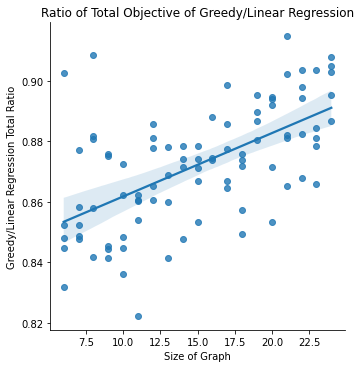

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

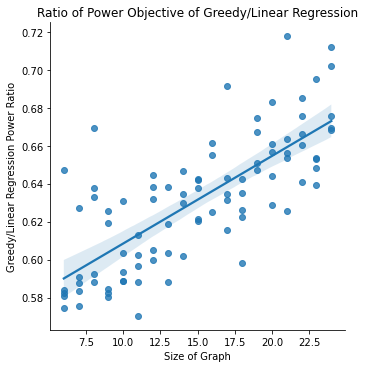

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

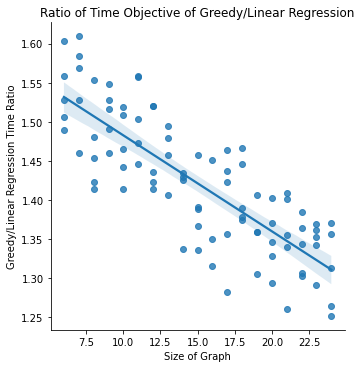

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# # Run model on test data and visualize prediction accuracy
# y_hat = lr.predict(X_test)
# print("predictions are ",y_hat)
# plt.figure(figsize=(16,8))
# sns.distplot(y_hat, hist = False, label = f'Predicted Pseudosize')
# sns.distplot(Y_test, hist = False, label = f'Actual Pseudosize')
# plt.title(f'Actual vs Predicted Pseudosize')
# plt.xlabel('Pseudosize')
# plt.ylabel('Density')
# plt.show()
plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths})

plt.figure(figsize=(16,8))
sns.lmplot("size", "objective_ratio", plt_df, order=1)
plt.title("Ratio of Total Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Total Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "power_ratio", plt_df, order=1)
plt.title("Ratio of Power Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Power Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "time_ratio", plt_df, order=1)
plt.title("Ratio of Time Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Time Ratio")
plt.show()

# Plots based on the Loss (OLS)

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

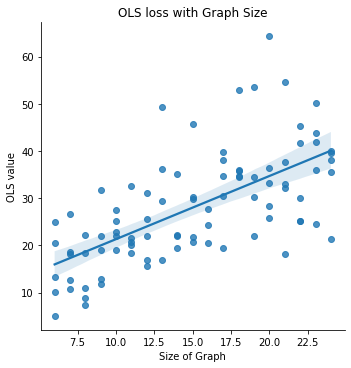

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

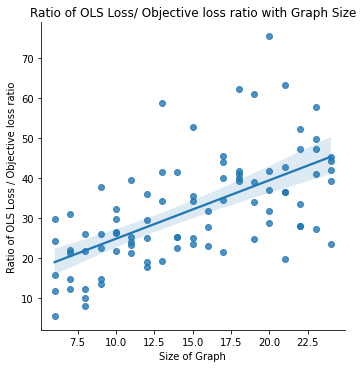

Mean OLS loss is  27.980093974364046
Square root of OLS loss is  5.289621345083601


In [14]:
import statistics

def ols(list1, list2):
    return [(l1-l2)**2 for l1, l2 in zip(list1, list2)]

# #print(y_hat)
# #print(Y_test)
# y_hat = list(y_hat)
mean_squares = [statistics.mean(ols(g, l)) for g, l in zip(greedy_psizes, lr_psizes)]
loss_ratio = [a / b for a, b in zip(mean_squares, objective_comparisons)]

plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths, "ols_loss":mean_squares, "loss_ratio":loss_ratio})

plt.figure(figsize=(16,8))
sns.lmplot("size", "ols_loss", plt_df, order=1)
plt.title("OLS loss with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("OLS value")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "loss_ratio", plt_df, order=1)
plt.title("Ratio of OLS Loss/ Objective loss ratio with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("Ratio of OLS Loss / Objective loss ratio")
plt.show()

mean_loss = statistics.mean(mean_squares)
print("Mean OLS loss is ", mean_loss)
print("Square root of OLS loss is ", mean_loss ** (0.5))


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

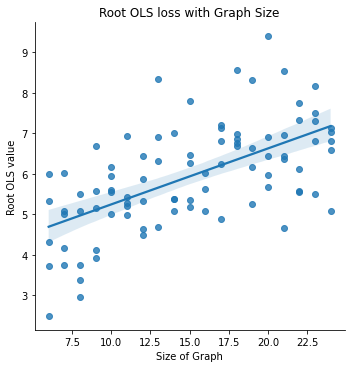

In [15]:
import statistics

def ols(list1, list2):
    return [(l1-l2)**2 for l1, l2 in zip(list1, list2)]

# #print(y_hat)
# #print(Y_test)
# y_hat = list(y_hat)
root_mean_squares = [statistics.mean(ols(g, l))**0.5 for g, l in zip(greedy_psizes, lr_psizes)]
root_loss_ratio = [a / b for a, b in zip(root_mean_squares, objective_comparisons)]

plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths, "ols_loss":mean_squares, "loss_ratio":loss_ratio, "root_loss_ratio":root_loss_ratio})

plt.figure(figsize=(16,8))
sns.lmplot("size", "root_loss_ratio", plt_df, order=1)
plt.title("Root OLS loss with Graph Size")
plt.xlabel("Size of Graph")
plt.ylabel("Root OLS value")
plt.show()

